<a href="https://colab.research.google.com/github/kitouras/handwritten-text-segmentation/blob/main/segmentation_catalyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentations is successfully installed!"
import albumentations as A

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-y5w8hrp9
Albumentations is successfully installed!


In [2]:
!pip install -U catalyst > /dev/null && echo "Catalyst is successfully installed!"

Catalyst is successfully installed!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import cv2
import pandas as pd
import json
import os
import ast
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import GaussianBlur, ToGray
from torch import optim
import torchvision
import math
import random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pdb
import torch.nn.functional as F
from catalyst import dl, metrics
from catalyst.contrib.nn import TrevskyLoss
%matplotlib inline

# Download and unzip dataset

In [5]:
%%shell

wget https://storage.googleapis.com/handwritten_rus/SEGMENTATION/comptech_segmentation_handwritten.zip .
wget https://storage.googleapis.com/handwritten_rus/SEGMENTATION/images.tsv .
unzip comptech_segmentation_handwritten.zip

--2021-07-24 07:32:37--  https://storage.googleapis.com/handwritten_rus/SEGMENTATION/comptech_segmentation_handwritten.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63756948 (61M) [application/x-zip-compressed]
Saving to: ‘comptech_segmentation_handwritten.zip’

comptech_segmentati 100%[===================>]  60.80M  64.0MB/s    in 0.9s    

2021-07-24 07:32:39 (64.0 MB/s) - ‘comptech_segmentation_handwritten.zip’ saved [63756948/63756948]

--2021-07-24 07:32:39--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-24 07:32:39--
Total wall clock time: 1.9s
Downloaded: 1 files, 61M in 0.9s (64.0 MB/s)
--2021-07-24 07:32:39--  https://storage.googleapis.com/handwritten_rus/SEGMENTATION/im

# Hyperparameters


In [6]:
# Hyperparameters etc.
LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 768 
IMAGE_WIDTH = 768 
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "/content/train_images/"
TRAIN_MASK_DIR = "/content/train_masks/"
VAL_IMG_DIR = "/content/valid_images/"
VAL_MASK_DIR = "/content/valid_masks/"

# Data Preprocessing

In [7]:
data_path = r'comptech_segmentation_handwritten/images/'
data_path_unlabeled = r'comptech_segmentation_handwritten/unlabeled_images/'
data = pd.read_csv("images.tsv", sep='\t')
output_results = data["OUTPUT:result"].values
input_images = data["INPUT:image"].values
! mkdir /content/train_masks
! mkdir /content/train_images
! mkdir /content/valid_masks
! mkdir /content/valid_images

In [8]:
image_count = len(os.listdir(data_path))
img_mean_sum = 0
img_std_sum = 0
data_indices = np.arange(image_count)
np.random.shuffle(data_indices)
train_indices = data_indices[:round(len(data_indices)*0.8)]

# Creation of mask images from csv.

for image_idx, image in enumerate(os.listdir(data_path)):
  img = cv2.imread(os.path.join(data_path,image))
  img_mean_sum += np.mean(img)
  img_std_sum += np.std(img)
  im_name = f'/comptech-segmentation1/{image}'
  height = img.shape[0]
  width = img.shape[1]
  cond = data[data['INPUT:image'] == im_name]
  mask = np.zeros((height,width),dtype=np.uint8)


  for shape in cond['OUTPUT:result']:
    shape = ast.literal_eval(shape)
    if shape[0]['type'] == 'polygon':
      pass
    else:
      for s in shape:
        l0_p1 = s['data']['p1']
        l0_p2 = s['data']['p2']
        start = [
            int(width * l0_p1['x']),
            int(height * l0_p1['y'])
        ]
        end = [int(width * l0_p2['x']), int(height * l0_p2['y'])]
        if start[0] > end[0]:
          start[0], end[0] = end[0], start[0]
        if start[1] > end[1]:
          start[1], end[1] = end[1], start[1]
        start, end = tuple(start),  tuple(end)
        try:
          mask[start[1]:end[1], start[0]:end[0]] = 255
        except Exception as exc:
          print('Error')
          continue
      if image_idx in train_indices:
        cv2.imwrite(f'{TRAIN_MASK_DIR}{image}', mask)
        cv2.imwrite(f'{TRAIN_IMG_DIR}{image}', img)
      else:
        cv2.imwrite(f'{VAL_MASK_DIR}{image}', mask)
        cv2.imwrite(f'{VAL_IMG_DIR}{image}', img)

img_mean = img_mean_sum/image_count
img_mean_std = img_std_sum/image_count

In [9]:
#dataset class for a segmentation task
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_dir, self.images[index])
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return {"image": image, "mask": mask}

In [10]:
NORMALIZATION_FACTOR = 512
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=15, p=1),
            A.RandomSizedCrop(min_max_height=(IMAGE_HEIGHT//2, IMAGE_HEIGHT), height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=0.5),
            A.RandomRotate90(p=1),
            A.CLAHE(p=0.8),
            A.RandomBrightnessContrast(p=0.8),    
            A.RandomGamma(p=0.8),
         
            A.Normalize(img_mean/NORMALIZATION_FACTOR, img_mean_std/NORMALIZATION_FACTOR),
            GaussianBlur(p=1),
            ToGray(p=1),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
    [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(img_mean/NORMALIZATION_FACTOR, img_mean_std/NORMALIZATION_FACTOR),
            GaussianBlur(p=1),
            ToGray(p=1),
            ToTensorV2(),
        ],
)

In [11]:
train_ds = SegDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=train_transform,
    )
val_ds = SegDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transform,
)

In [12]:
loaders = {
    "train": DataLoader(
      train_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
    ),
    "valid": DataLoader(
      val_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
    )
}

# Data visualisation


In [16]:
data_batch = next(iter(loaders["valid"]))

In [17]:
test_img = data_batch["image"][0].numpy().transpose((1, 2, 0))
# Граница настраиваемая из-за разного распределения изображений
_, test_img = cv2.threshold(test_img,5,255,cv2.THRESH_BINARY)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

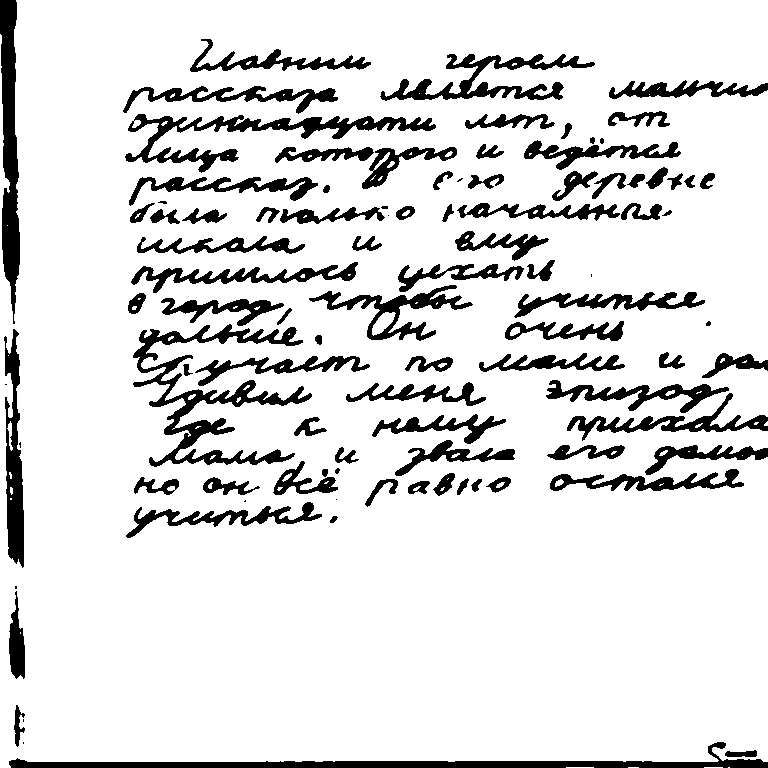

In [18]:
# Изображение из валидационного датасета
cv2_imshow(test_img)

In [19]:
test_mask = data_batch["mask"][0].numpy()
_, test_mask = cv2.threshold(test_mask,0.5,255,cv2.THRESH_BINARY)

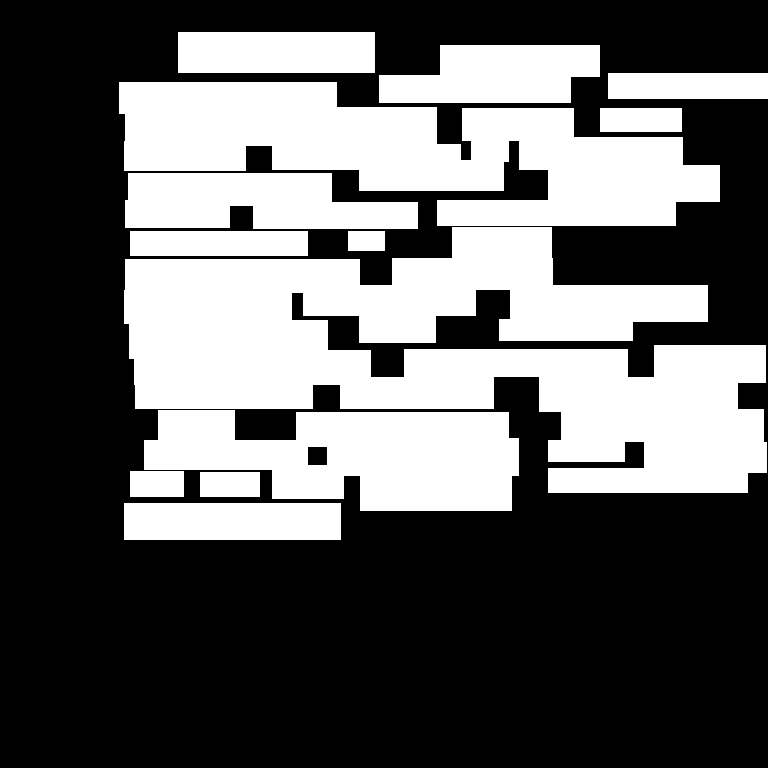

In [20]:
# Маска из валидационного датасета
cv2_imshow(test_mask)

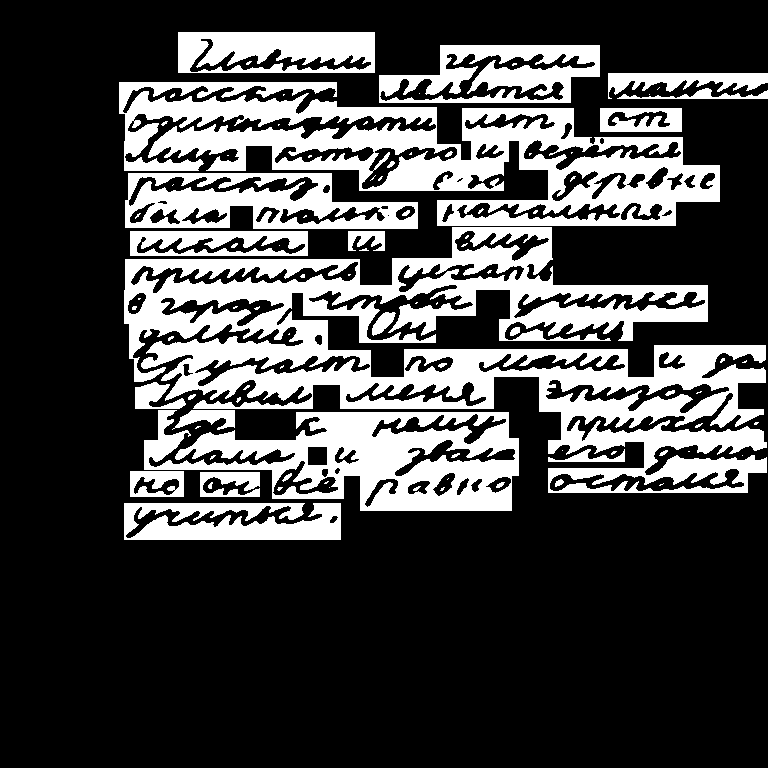

In [21]:
# Наложение маски на изображение

test_multiply = cv2.multiply(test_img, test_mask.astype('float32'))
cv2_imshow(test_multiply)

# Model

In [22]:
class GaborFilters(nn.Module):
    def __init__(self,
                 in_channels,
                 n_sigmas=3,
                 n_lambdas=4,
                 n_gammas=1,
                 n_thetas=7,
                 kernel_radius=15,
                 rotation_invariant=True
                 ):
        super().__init__()
        self.in_channels = in_channels
        kernel_size = kernel_radius * 2 + 1
        self.kernel_size = kernel_size
        self.kernel_radius = kernel_radius
        self.n_thetas = n_thetas
        self.rotation_invariant = rotation_invariant

        def make_param(in_channels, values, requires_grad=True, dtype=None):
            if dtype is None:
                dtype = 'float32'
            values = np.require(values, dtype=dtype)
            n = in_channels * len(values)
            data = torch.from_numpy(values).view(1, -1)
            data = data.repeat(in_channels, 1)
            return torch.nn.Parameter(data=data, requires_grad=requires_grad)

        # build all learnable parameters
        self.sigmas = make_param(in_channels, 2 ** np.arange(n_sigmas) * 2)
        self.lambdas = make_param(in_channels, 2 ** np.arange(n_lambdas) * 4.0)
        self.gammas = make_param(in_channels, np.ones(n_gammas) * 0.5)
        self.psis = make_param(in_channels, np.array([0, math.pi / 2.0]))

        thetas = np.linspace(0.0, 2.0 * math.pi, num=n_thetas, endpoint=False)
        thetas = torch.from_numpy(thetas).float()
        self.register_buffer('thetas', thetas)

        indices = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
        self.register_buffer('indices', indices)

        # number of channels after the conv
        self._n_channels_post_conv = self.in_channels * self.sigmas.shape[1] * \
                                     self.lambdas.shape[1] * self.gammas.shape[1] * \
                                     self.psis.shape[1] * self.thetas.shape[0]

    def make_gabor_filters(self):

        sigmas = self.sigmas
        lambdas = self.lambdas
        gammas = self.gammas
        psis = self.psis
        thetas = self.thetas
        y = self.indices
        x = self.indices

        in_channels = sigmas.shape[0]
        assert in_channels == lambdas.shape[0]
        assert in_channels == gammas.shape[0]

        kernel_size = y.shape[0], x.shape[0]

        sigmas = sigmas.view(in_channels, sigmas.shape[1], 1, 1, 1, 1, 1, 1)
        lambdas = lambdas.view(in_channels, 1, lambdas.shape[1], 1, 1, 1, 1, 1)
        gammas = gammas.view(in_channels, 1, 1, gammas.shape[1], 1, 1, 1, 1)
        psis = psis.view(in_channels, 1, 1, 1, psis.shape[1], 1, 1, 1)

        thetas = thetas.view(1, 1, 1, 1, 1, thetas.shape[0], 1, 1)
        y = y.view(1, 1, 1, 1, 1, 1, y.shape[0], 1)
        x = x.view(1, 1, 1, 1, 1, 1, 1, x.shape[0])

        sigma_x = sigmas
        sigma_y = sigmas / gammas

        sin_t = torch.sin(thetas)
        cos_t = torch.cos(thetas)
        y_theta = -x * sin_t + y * cos_t
        x_theta = x * cos_t + y * sin_t

        gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) \
             * torch.cos(2.0 * math.pi * x_theta / lambdas + psis)

        gb = gb.view(-1, kernel_size[0], kernel_size[1])
        if torch.cuda.is_available():
            gb = gb.to('cuda')
        return gb

    def forward(self, x):
        batch_size = x.size(0)
        sy = x.size(2)
        sx = x.size(3)
        gb = self.make_gabor_filters()

        assert gb.shape[0] == self._n_channels_post_conv
        assert gb.shape[1] == self.kernel_size
        assert gb.shape[2] == self.kernel_size
        gb = gb.view(self._n_channels_post_conv, 1, self.kernel_size, self.kernel_size)

        res = nn.functional.conv2d(input=x, weight=gb,
                                   padding=self.kernel_radius, groups=self.in_channels)

        if self.rotation_invariant:
            res = res.view(batch_size, self.in_channels, -1, self.n_thetas, sy, sx)
            res, _ = res.max(dim=3)

        res = res.view(batch_size, -1, sy, sx)

        return res


In [23]:
class Morphology(nn.Module):
    '''
    Base class for morpholigical operators 
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''

    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure. 
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1)  # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x  # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x  # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False)  # (B, Cout, L)
        else:
            x = torch.logsumexp(x * self.beta, dim=2, keepdim=False) / self.beta  # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x


class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')


class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.gabor = GaborFilters(in_channels)
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        in_channels = 72  # gabor's filter output channels
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.erode = Erosion2d(out_channels, out_channels)
        self.dilate = Dilation2d(out_channels, out_channels)

    def forward(self, x):
        skip_connections = []
        x = x.float()
        x = self.gabor(x)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        for _ in range(2):
            x = self.erode(x)
            x = self.dilate(x)
        x = self.dilate(x)
        return x

# Utils

In [25]:
def get_accuracy(logits, y):
  preds = torch.sigmoid(logits)
  preds = (preds > 0.5).float()
  num_correct = (preds == y).sum()
  num_pixels = torch.numel(preds)
  return num_correct/num_pixels*100

In [61]:
def plot_metric(metric_name, steps, train_metric, valid_metric):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(steps, train_metric)
  ax1.set_title(f'Train {metric_name}')
  ax1.set_yscale('log')
  ax2.plot(steps, valid_metric)
  ax2.set_title(f'Valid {metric_name}')
  ax2.set_yscale('log')
  plt.show()

In [26]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        x = self.model(batch["image"].to(self.device))
        x = torch.sigmoid(x)
        return (x > 0.5).float()

    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "accuracy"]
        }

    def handle_batch(self, batch):
        # model train/valid step
        # unpack the batch
        x, y = batch["image"], batch["mask"]
        y = y.float().unsqueeze(1)
        # run model forward pass
        logits = self.model(x)
        # compute the loss
        loss = self.criterion(logits, y)
        # compute the metrics
        accuracy = get_accuracy(logits, y)
        # log metrics
        self.batch_metrics.update(
            {"loss": loss, "accuracy": accuracy}
        )
        for key in ["loss", "accuracy"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)
        # run model backward pass
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def on_loader_end(self, runner):
        for key in ["loss", "accuracy"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

In [27]:
ALPHA = 0.7
BETA = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)  
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        ones_tensor = 1 + 1e-6
        #True Positives, False Positives & False Negatives
        TP = torch.sum(inputs * targets)    
        FP = torch.sum((-targets + ones_tensor) * inputs)
        FN = torch.sum(targets * (-inputs + ones_tensor))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
        

In [28]:
def save_checkpoint(state, filename="/content/drive/MyDrive/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(model, filename="/content/drive/MyDrive/checkpoint.pth.tar"):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["state_dict"])

# Train

In [29]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
criterion = TverskyLoss()

In [30]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [31]:
runner = CustomRunner()

In [32]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=NUM_EPOCHS,
    logdir="./logdir",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



train (1/50) accuracy: 67.90429433186848 | loss: 0.3907460305425856



valid (1/50) accuracy: 62.8927001953125 | loss: 0.725954681634903
* Epoch (1/50) 



train (2/50) accuracy: 73.11102718777127 | loss: 0.32858612802293563



valid (2/50) accuracy: 65.78547286987305 | loss: 0.6462528705596924
* Epoch (2/50) 



train (3/50) accuracy: 73.48654429117839 | loss: 0.3131108482678731



valid (3/50) accuracy: 72.19022369384766 | loss: 0.43809840083122253
* Epoch (3/50) 



train (4/50) accuracy: 72.6716317070855 | loss: 0.3200329939524333



valid (4/50) accuracy: 56.520761489868164 | loss: 0.9629571437835693
* Epoch (4/50) 



train (5/50) accuracy: 73.98144870334201 | loss: 0.29813732703526813



valid (5/50) accuracy: 56.25631523132324 | loss: 0.9981136322021484
* Epoch (5/50) 



train (6/50) accuracy: 73.13828786214192 | loss: 0.29504917727576363



valid (6/50) accuracy: 60.353981018066406 | loss: 0.8150249719619751
* Epoch (6/50) 



train (7/50) accuracy: 76.08887651231554 | loss: 0.2715556157959832



valid (7/50) accuracy: 79.00246810913086 | loss: 0.25722816586494446
* Epoch (7/50) 



train (8/50) accuracy: 76.68289608425565 | loss: 0.272793259885576



valid (8/50) accuracy: 60.84959411621094 | loss: 0.716970831155777
* Epoch (8/50) 



train (9/50) accuracy: 75.29645453559029 | loss: 0.2775205042627123



valid (9/50) accuracy: 58.00967979431152 | loss: 0.9036328196525574
* Epoch (9/50) 



train (10/50) accuracy: 76.06183200412326 | loss: 0.28407225343916154



valid (10/50) accuracy: 66.70981216430664 | loss: 0.49420446157455444
* Epoch (10/50) 



train (11/50) accuracy: 78.04785919189453 | loss: 0.2354063457912869



valid (11/50) accuracy: 61.98603630065918 | loss: 0.767183780670166
* Epoch (11/50) 



train (12/50) accuracy: 78.73692406548395 | loss: 0.2394315136803521



valid (12/50) accuracy: 81.77650833129883 | loss: 0.23202583193778992
* Epoch (12/50) 



train (13/50) accuracy: 78.31042226155598 | loss: 0.23355513148837617



valid (13/50) accuracy: 71.85952758789062 | loss: 0.31682589650154114
* Epoch (13/50) 



train (14/50) accuracy: 76.05353546142578 | loss: 0.2578451964590284



valid (14/50) accuracy: 65.84053230285645 | loss: 0.46348822116851807
* Epoch (14/50) 



train (15/50) accuracy: 81.3924831814236 | loss: 0.19716889990700615



valid (15/50) accuracy: 56.277509689331055 | loss: 0.9945376217365265
* Epoch (15/50) 



train (16/50) accuracy: 72.95629204644098 | loss: 0.30423334572050303



valid (16/50) accuracy: 69.80862426757812 | loss: 0.4640558660030365
* Epoch (16/50) 



train (17/50) accuracy: 75.41133880615236 | loss: 0.29448164171642727



valid (17/50) accuracy: 60.44302940368652 | loss: 0.7772566676139832
* Epoch (17/50) 



train (18/50) accuracy: 78.39285024007161 | loss: 0.24125180641810098



valid (18/50) accuracy: 83.88188934326172 | loss: 0.21322599053382874
* Epoch (18/50) 



train (19/50) accuracy: 78.58644782172308 | loss: 0.23844667275746664



valid (19/50) accuracy: 86.02375793457031 | loss: 0.17245793342590332
* Epoch (19/50) 



train (20/50) accuracy: 78.7436786227756 | loss: 0.22320456637276542



valid (20/50) accuracy: 82.99433517456055 | loss: 0.20731782913208008
* Epoch (20/50) 



train (21/50) accuracy: 80.63328297932942 | loss: 0.21530971262190077



valid (21/50) accuracy: 82.66766738891602 | loss: 0.22180303931236267
* Epoch (21/50) 



train (22/50) accuracy: 80.16166517469618 | loss: 0.21985069910685218



valid (22/50) accuracy: 81.1637077331543 | loss: 0.22404402494430542
* Epoch (22/50) 



train (23/50) accuracy: 79.60860866970486 | loss: 0.23890967501534355



valid (23/50) accuracy: 62.28625297546387 | loss: 0.6687439382076263
* Epoch (23/50) 



train (24/50) accuracy: 77.7280010647244 | loss: 0.24435511562559337



valid (24/50) accuracy: 68.62017059326172 | loss: 0.5249801874160767
* Epoch (24/50) 



train (25/50) accuracy: 79.58410814073352 | loss: 0.23047572374343872



valid (25/50) accuracy: 56.44985008239746 | loss: 0.9848841726779938
* Epoch (25/50) 



train (26/50) accuracy: 79.87703874376085 | loss: 0.24132551749547324



valid (26/50) accuracy: 84.59845352172852 | loss: 0.19513961672782898
* Epoch (26/50) 



train (27/50) accuracy: 77.5027067396376 | loss: 0.2689628468619452



valid (27/50) accuracy: 63.789113998413086 | loss: 0.7180099785327911
* Epoch (27/50) 



train (28/50) accuracy: 77.5881716410319 | loss: 0.23016244835323757



valid (28/50) accuracy: 79.6485481262207 | loss: 0.22102093696594238
* Epoch (28/50) 



train (29/50) accuracy: 78.77569580078125 | loss: 0.23576729165183175



valid (29/50) accuracy: 76.31687545776367 | loss: 0.2729629874229431
* Epoch (29/50) 



train (30/50) accuracy: 76.21229553222656 | loss: 0.2514481544494629



valid (30/50) accuracy: 68.97557830810547 | loss: 0.5509016215801239
* Epoch (30/50) 



train (31/50) accuracy: 78.77494049072266 | loss: 0.24077873759799534



valid (31/50) accuracy: 77.54304885864258 | loss: 0.2836257219314575
* Epoch (31/50) 



train (32/50) accuracy: 79.75967576768663 | loss: 0.21769062015745372



valid (32/50) accuracy: 80.9981460571289 | loss: 0.2802753448486328
* Epoch (32/50) 



train (33/50) accuracy: 78.47986348470052 | loss: 0.24216683705647787



valid (33/50) accuracy: 84.43879318237305 | loss: 0.19824299216270447
* Epoch (33/50) 



train (34/50) accuracy: 80.1177249484592 | loss: 0.20449611875745985



valid (34/50) accuracy: 56.45849418640137 | loss: 0.9819464981555939
* Epoch (34/50) 



train (35/50) accuracy: 78.28813934326172 | loss: 0.2598324815432231



valid (35/50) accuracy: 81.84657669067383 | loss: 0.22888249158859253
* Epoch (35/50) 



train (36/50) accuracy: 75.9779561360677 | loss: 0.27071814404593575



valid (36/50) accuracy: 85.18070983886719 | loss: 0.1716473400592804
* Epoch (36/50) 



train (37/50) accuracy: 77.46767679850261 | loss: 0.23860977093378702



valid (37/50) accuracy: 85.97247314453125 | loss: 0.15277114510536194
* Epoch (37/50) 



train (38/50) accuracy: 79.95943620469835 | loss: 0.24235041273964775



valid (38/50) accuracy: 82.67681884765625 | loss: 0.22020894289016724
* Epoch (38/50) 



train (39/50) accuracy: 80.20611741807724 | loss: 0.20558971828884548



valid (39/50) accuracy: 65.80526733398438 | loss: 0.5173938870429993
* Epoch (39/50) 



train (40/50) accuracy: 81.08164638943143 | loss: 0.2039704190360175



valid (40/50) accuracy: 83.62079238891602 | loss: 0.18007099628448486
* Epoch (40/50) 



train (41/50) accuracy: 76.20518027411566 | loss: 0.24637919664382935



valid (41/50) accuracy: 79.63790893554688 | loss: 0.2518252730369568
* Epoch (41/50) 



train (42/50) accuracy: 79.23107571072049 | loss: 0.2348919047249688



valid (42/50) accuracy: 56.40254592895508 | loss: 0.9859066903591156
* Epoch (42/50) 



train (43/50) accuracy: 80.57338799370659 | loss: 0.2134566174613105



valid (43/50) accuracy: 74.507568359375 | loss: 0.31450626254081726
* Epoch (43/50) 



train (44/50) accuracy: 80.0037824842665 | loss: 0.23142566945817739



valid (44/50) accuracy: 68.85181045532227 | loss: 0.564170241355896
* Epoch (44/50) 



train (45/50) accuracy: 78.4904301961263 | loss: 0.22960754897859362



valid (45/50) accuracy: 65.62567520141602 | loss: 0.525491863489151
* Epoch (45/50) 



train (46/50) accuracy: 80.38038974338107 | loss: 0.23139973481496176



valid (46/50) accuracy: 80.24983215332031 | loss: 0.249904066324234
* Epoch (46/50) 



train (47/50) accuracy: 81.82815890842014 | loss: 0.19721483521991306



valid (47/50) accuracy: 80.66897964477539 | loss: 0.21407493948936462
* Epoch (47/50) 



train (48/50) accuracy: 80.84897698296442 | loss: 0.1885596646202935



valid (48/50) accuracy: 82.18307876586914 | loss: 0.2126125991344452
* Epoch (48/50) 



train (49/50) accuracy: 83.41026645236546 | loss: 0.19568735361099243



valid (49/50) accuracy: 87.53009414672852 | loss: 0.14316537976264954
* Epoch (49/50) 



train (50/50) accuracy: 82.56139967176648 | loss: 0.19199032253689233



valid (50/50) accuracy: 86.53001022338867 | loss: 0.15113824605941772
* Epoch (50/50) 
Top best models:
logdir/checkpoints/train.49.pth	0.1432


In [33]:
train_losses = pd.read_csv('/content/logdir/logs/train.csv')
valid_losses = pd.read_csv('/content/logdir/logs/valid.csv')

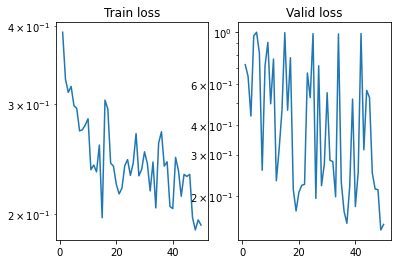

In [62]:
plot_metric('loss', train_losses['step'], train_losses['loss'], valid_losses['loss'])

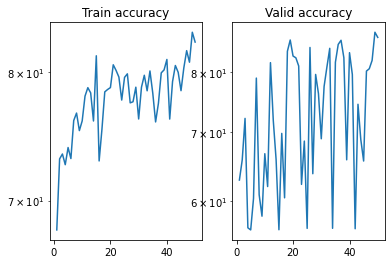

In [134]:
plot_metric('accuracy', train_losses['step'], train_losses['accuracy'], valid_losses['accuracy'])

# Test

In [135]:
img_path = '/content/comptech_segmentation_handwritten/unlabeled_images/12_4.jpg'
test_img = cv2.imread(img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_tensor = val_transform(image=test_img)["image"]
test_img_tensor = torch.unsqueeze(test_img_tensor, 0)
test_img_tensor = test_img_tensor.to(DEVICE)
test_img_dict = {'image': test_img_tensor}

In [136]:
preds = runner.predict_batch(test_img_dict)[0]

In [137]:
test_mask = preds.squeeze(0).detach().cpu().numpy()
_, test_mask = cv2.threshold(test_mask,0.5,255,cv2.THRESH_BINARY)

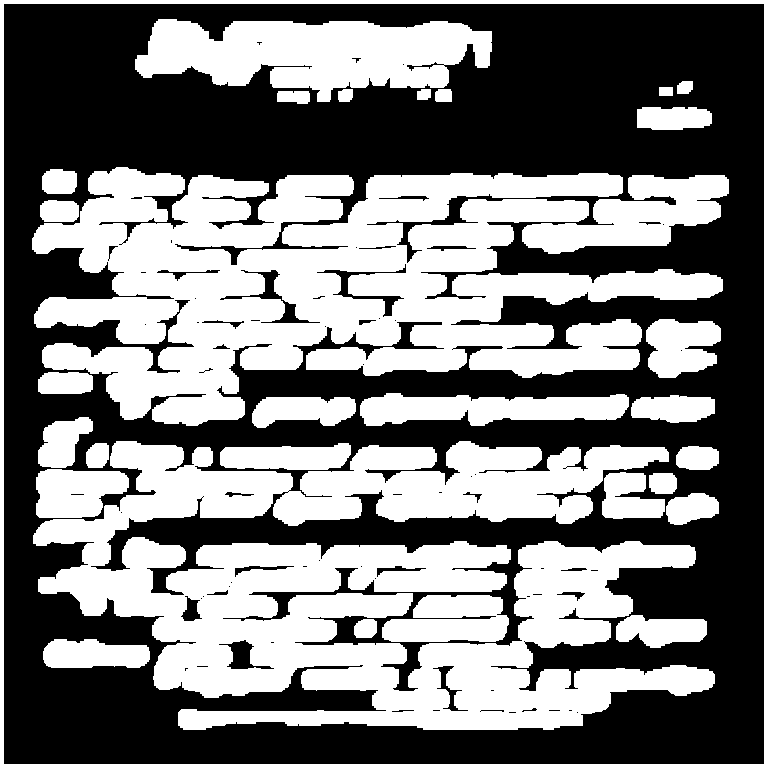

In [138]:
# Выход из модели
cv2_imshow(test_mask)

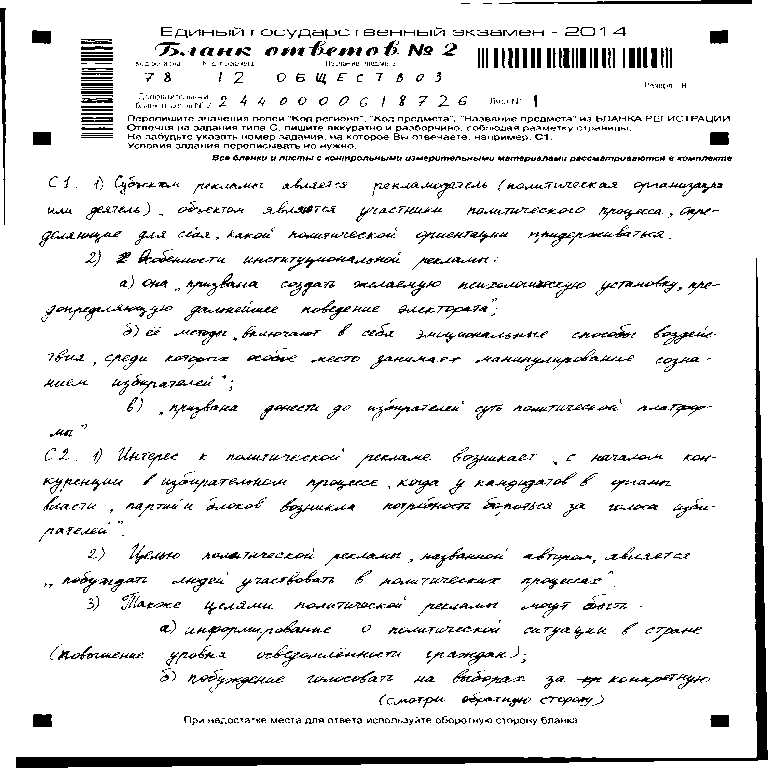

In [139]:
# Тестовое (неразмеченное) изображение
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
test_img = cv2.resize(test_img, (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_AREA)
_, test_img = cv2.threshold(test_img,127,255,cv2.THRESH_BINARY)
cv2_imshow(test_img)

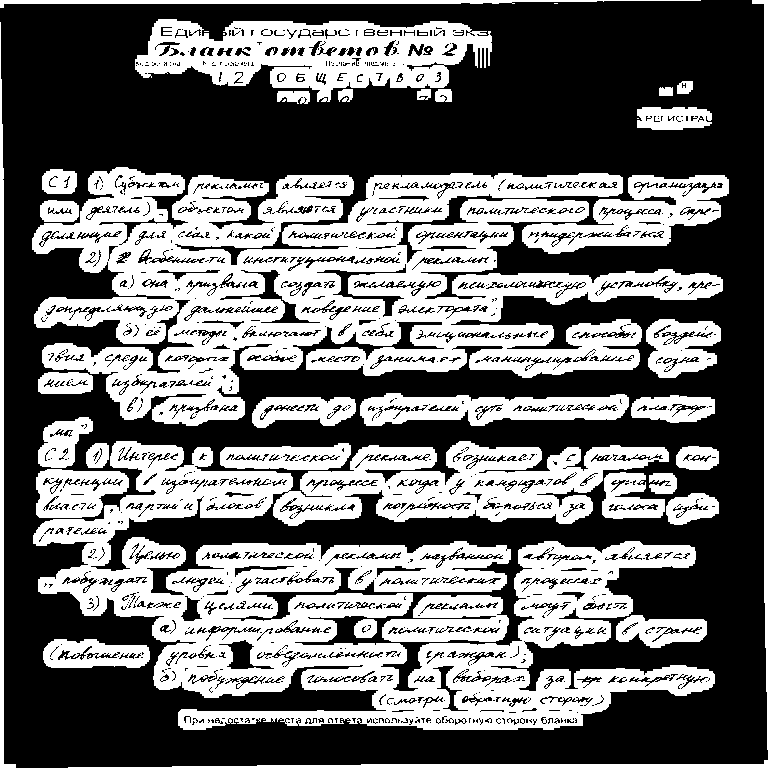

In [140]:
# Наложение маски на тестовое изображение
test_multiply = cv2.multiply(test_img, test_mask.astype('uint8'))
cv2_imshow(test_multiply)